# Multimodal Calssification on Rakuten France Dataset
# Multi Modal Addition Fusion

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls

drive  sample_data


In [4]:
pwd

'/content'

In [5]:
mkdir Rakuten

In [6]:
cd './Rakuten'

/content/Rakuten


In [7]:
mkdir models data 

In [8]:
pwd

'/content/Rakuten'

In [9]:
cp '/content/drive/My Drive/Rakuten/models/CamemBERT_best_model_split_title.pt' models

In [10]:
cp '/content/drive/My Drive/Rakuten/models/CamemBERT_best_model_split_description.pt' models


In [11]:
cp '/content/drive/My Drive/Rakuten/models/FlauBERT_best_model_split_description.pt' models

In [12]:
cp '/content/drive/My Drive/Rakuten/models/FlauBERT_best_model_split_title.pt' models


In [13]:
cp '/content/drive/My Drive/Rakuten/models/RESNET_baseline_model.pt' models

In [14]:
pwd

'/content/Rakuten'

In [15]:
!cp  '/content/drive/My Drive/Rakuten/image.zip' './'

In [16]:
ls -la

total 2182588
drwxr-xr-x 4 root root       4096 May  9 22:19 ./
drwxr-xr-x 1 root root       4096 May  9 22:17 ../
drwxr-xr-x 2 root root       4096 May  9 22:17 data/
-rw------- 1 root root 2234946752 May  9 22:20 image.zip
drwxr-xr-x 2 root root       4096 May  9 22:19 models/


In [17]:
!unzip  ./image.zip

Streaming output truncated to the last 5000 lines.
  inflating: image/image_training/image_941622041_product_207151319.jpg  
  inflating: image/image_training/image_941622046_product_207151571.jpg  
  inflating: image/image_training/image_941622048_product_207151338.jpg  
  inflating: image/image_training/image_941622055_product_207151480.jpg  
  inflating: image/image_training/image_941622057_product_207151296.jpg  
  inflating: image/image_training/image_941622063_product_207151539.jpg  
  inflating: image/image_training/image_941622065_product_207151527.jpg  
  inflating: image/image_training/image_941622067_product_207151563.jpg  
  inflating: image/image_training/image_941622071_product_207151331.jpg  
  inflating: image/image_training/image_941622073_product_207151492.jpg  
  inflating: image/image_training/image_941622084_product_207151508.jpg  
  inflating: image/image_training/image_941622086_product_207151543.jpg  
  inflating: image/image_training/image_941622094_product_207

In [18]:
pwd

'/content/Rakuten'

In [19]:
 !cp '/content/drive/My Drive/Rakuten/data/NewTest.csv' data 
 !cp '/content/drive/My Drive/Rakuten/data/NewTraining.csv' data 
 !cp '/content/drive/My Drive/Rakuten/data/catalog_english_taxonomy.tsv' data 
 !cp '/content/drive/My Drive/Rakuten/data/Y_train.tsv' data 
 !cp '/content/drive/My Drive/Rakuten/data/X_train.tsv' data

In [20]:
pwd

'/content/Rakuten'

# 1. Setup

# 1.1 Using Colab GPU for Training

Since we’ll be training a large neural network it’s best to take advantage of the free GPUs and TPUs that Google offers (in this case we’ll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)

In [21]:
import os, time, datetime
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import random
import logging
tqdm.pandas()
import seaborn as sns
from sklearn.model_selection import train_test_split
from google.colab import drive

#NN Packages
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, random_split,DataLoader, RandomSampler, SequentialSampler

logger = logging.getLogger(__name__)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [22]:
torch.manual_seed(123)
torch.cuda.manual_seed(123)
torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic=True

In [23]:
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [24]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun May  9 22:21:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1.2. Installing the Hugging Face Library - Image Pretrained Models

Install the transformers package from **Hugging Face** which will give us a pytorch interface for working with BERT. This library contains interfaces for other pretrained language models.

We’ve selected the pytorch interface because it strikes a nice balance between the high-level APIs (which are easy to use but don’t provide insight into how things work) and tensorflow code (which contains lots of details but often sidetracks us into lessons about tensorflow, when the purpose here is BERT!).

At the moment, the Hugging Face library seems to be the most widely accepted and powerful pytorch interface for working with BERT. In addition to supporting a variety of different pre-trained transformer models, the library also includes pre-built modifications of these models suited to your specific task.
E.g "BertForSequenceClassification" that we will be using.

The goal  of the **pretrainedmodels** is to:

-  help to reproduce transfer learning setups

-  access pretrained ConvNets with a unique interface/API inspired by torchvision.

In [25]:
!pip install transformers
!pip install sentencepiece
!pip install pretrainedmodels

     |████████████████████████████████| 2.1MB 4.3MB/s 
     |████████████████████████████████| 901kB 18.4MB/s 
     |████████████████████████████████| 3.3MB 29.4MB/s 
     |████████████████████████████████| 1.2MB 4.2MB/s 
     |████████████████████████████████| 61kB 2.8MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60963 sha256=8a2db4b52180174cf5646919e26e8f443377210222d328f0c015942b3d0c7aa9
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels


# 2. Dataset Loading and Preprocessing

# 2.1 Dataset Loading

In [26]:
text_data_path = '/content/Rakuten/data'
image_data_path = '/content/Rakuten/image' 

In [27]:
class SigirPreprocess():

  def __init__(self, text_data_path):
    
        self.text_data_path = text_data_path
        self.train = None # Merged X_train and Y_train
        self.dict_code_to_id = {}
        self.dict_id_to_code = {}
        self.list_tags = {} #unique type code
        self.sentences = []
        self.labels = []
        self.text_col = None
        self.X_test = None

  def prepare_data(self):
        
        #loading the Merged, preprocessed text data and test data
        train = pd.read_csv(self.text_data_path+"/NewTraining.csv")
        # new_train =  train[train['Description'] != " "]
        # new_train = new_train[new_train['Description'].notna()]
        self.train = train

        
  def get_sentences(self, text_col, remove_null_rows=True):

       #get values of a specific column
        self.text_col = text_col        

        new_train = self.train.copy()  
        self.sentences = new_train[text_col].values
        self.labels = new_train['labels'].values


  def prepare_test(self, text_col):
    
        X_test = pd.read_csv(self.text_data_path + "/NewTest.csv")
        self.X_test = X_test
        X_test['title_desc'] = X_test['Title'] + " " + X_test['Description']
        self.test_sentences = X_test[text_col].values
        return self.test_sentences
        

# 2.2 Drop Records With No Description

In [28]:
#Load train and test data (test for specific column)

text_col = 'title_desc'

max_len = 256

num_classes = 27

Preprocess = SigirPreprocess(text_data_path)

Preprocess.prepare_data()
train = Preprocess.train
# print("Trian:  ", len(Preprocess.train))


Preprocess.get_sentences(text_col)
# print("Labels: ", len(Preprocess.labels))

# X_test = Preprocess.prepare_test(text_col)
# print("Test:   ", len(Preprocess.X_test))

In [29]:
from bs4 import BeautifulSoup
Preprocess.train['Description'] = [BeautifulSoup(text).get_text() for text in  Preprocess.train['Description'] ]
Preprocess.train['Title'] = [BeautifulSoup(text).get_text() for text in  Preprocess.train['Title'] ]
Preprocess.train['title_desc'] = [BeautifulSoup(text).get_text() for text in  Preprocess.train['title_desc'] ]


/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://placehold.it/100x70" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://www.pro-bems.com/IMAGES/images_1/FIGJJCT0000117/m/FIGJJCT0000117_5.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/usr/local/lib/python3.7/dist-pac

Class=2, n=1205 (2.190%)
Class=4, n=1736 (3.155%)
Class=5, n=3792 (6.891%)
Class=6, n=2526 (4.591%)
Class=7, n=4896 (8.898%)
Class=8, n=1578 (2.868%)
Class=9, n=4096 (7.444%)
Class=3, n=3802 (6.910%)
Class=11, n=945 (1.717%)
Class=14, n=3872 (7.037%)
Class=17, n=4707 (8.554%)
Class=12, n=9304 (16.909%)
Class=19, n=699 (1.270%)
Class=20, n=2140 (3.889%)
Class=1, n=320 (0.582%)
Class=21, n=2214 (4.024%)
Class=22, n=758 (1.378%)
Class=18, n=866 (1.574%)
Class=23, n=872 (1.585%)
Class=24, n=2296 (4.173%)
Class=25, n=681 (1.238%)
Class=16, n=349 (0.634%)
Class=26, n=701 (1.274%)
Class=0, n=338 (0.614%)
Class=13, n=153 (0.278%)
Class=10, n=126 (0.229%)
Class=15, n=53 (0.096%)



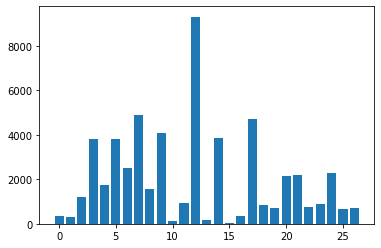

In [30]:
from collections import Counter
import matplotlib.pyplot as plt


counter = Counter(Preprocess.labels)
for k,v in counter.items():
	per = v / len(Preprocess.labels) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

print("")
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [31]:
print(Preprocess.train['Title'].isnull().sum())

print(Preprocess.train['Description'].isnull().sum())

print(Preprocess.train['Image_id'].isnull().sum())

print(Preprocess.train['Product_id'].isnull().sum())

print(Preprocess.train['Prdtypecode'].isnull().sum())

print(Preprocess.train['labels'].isnull().sum())

print(Preprocess.train['product'].isnull().sum()) #top level category

print(Preprocess.train['title_desc'].isnull().sum())




0
0
0
0
0
0
0
0


In [32]:
Preprocess.train.isnull().values.any()

False

In [33]:
Preprocess.train.isnull().sum().sum()

0

In [34]:
Preprocess.train

,Unnamed: 0,Unnamed: 0.1,Integer_id,Title,Description,Image_id,Product_id,Prdtypecode,labels,product,title_len,desc_len,title_desc_len,title_desc
0,0,2,2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,938777978,201115110,50,2,Entertainment,12,109,121,Grand Stylet Ergonomique Bleu Gamepad Nintendo...
1,1,4,4,La Guerre Des Tuques,Luc a des idées de grandeur. Il veut organiser...,1077757786,278535884,2705,4,Books,4,34,38,La Guerre Des Tuques Luc a des idées de grande...
2,2,7,7,Conquérant Sept Cahier Couverture Polypro 240 ...,CONQUERANT CLASSIQUE Cahier 240 x 320 mm seyès...,999581347,344240059,2522,5,Books,14,18,32,Conquérant Sept Cahier Couverture Polypro 240 ...
3,3,9,9,Tente Pliante V3s5-Pro Pvc Blanc - 3 X 4m50 - ...,Tente pliante V3S5 Pro PVC 500 gr/m² - 3 x 4m5...,1245644185,3793572222,2582,6,Household,19,293,312,Tente Pliante V3s5-Pro Pvc Blanc - 3 X 4m50 - ...
4,4,10,10,Eames Inspired Sxw Chair - Pink - Black,The timeless DSW seat can now be paired with m...,1111840281,1915836983,1560,7,Household,8,94,102,Eames Inspired Sxw Chair - Pink - Black The ti...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55020,55111,84908,84908,Dimmerable Usb Led Lampe De Bureau Réglable Ch...,Nom de la marque:oobestAmpoules incluses:OuiCe...,1313620762,4198481300,2060,17,Household,18,37,55,Dimmerable Usb Led Lampe De Bureau Réglable Ch...
55021,55112,84909,84909,espa - kit complet de nage à contre courant 39...,espa espa - kit complet de nage à contre coura...,1043841028,853455937,2583,12,Household,17,173,190,espa - kit complet de nage à contre courant 39...
55022,55113,84910,84910,Vêtements Pour Animaux Mode Style Chiens Rayé ...,le t - shirt rayé mode chiens petits chiots v...,1158527239,2699568414,2220,22,Household,12,168,180,Vêtements Pour Animaux Mode Style Chiens Rayé ...
55023,55114,84912,84912,Kit piscine acier NEVADA déco pierre Ø 3.50m x...,Description complète :Kit piscine hors-sol Toi...,1188462883,3065095706,2583,12,Household,10,190,200,Kit piscine acier NEVADA déco pierre Ø 3.50m x...


# View Tokenizer Input 

In [35]:
Preprocess.get_sentences(text_col,True)
sentences = Preprocess.sentences

labels = Preprocess.labels
print(sentences)


["Grand Stylet Ergonomique Bleu Gamepad Nintendo Wii U - Speedlink Pilot Style PILOT STYLE Touch Pen de marque Speedlink est 1 stylet ergonomique pour GamePad Nintendo Wii U. Pour un confort optimal et une précision maximale sur le GamePad de la Wii U: ce grand stylet hautement ergonomique est non seulement parfaitement adapté à votre main mais aussi très élégant. Il est livré avec un support qui se fixe sans adhésif à l'arrière du GamePad  Caractéristiques: Modèle: Speedlink PILOT STYLE Touch Pen Couleur: Bleu Ref. Fabricant: SL-3468-BE Compatibilité: GamePad Nintendo Wii U Forme particulièrement ergonomique excellente tenue en main Pointe à revêtement longue durée conçue pour ne pas abîmer l'écran tactile En bonus : Support inclu pour GamePad "
 "La Guerre Des Tuques Luc a des idées de grandeur. Il veut organiser un jeu de guerre de boules de neige et s'arranger pour en être le vainqueur incontesté. Mais Sophie s'en mêle et chambarde tous ses plans..."
 'Conquérant Sept Cahier Couver

In [36]:
print (type(sentences))
print()
# print("Total number of sentences:{}, labels:{}".format(len(sentences), len(labels)))

<class 'numpy.ndarray'>



# View Test Sentences

In [37]:
# batch_size = 32  

# test_sentences = Preprocess.test_sentences

# X_test_phase1  = Preprocess.X_test

In [38]:
# print(len(test_sentences))

**Helper Function**

In [39]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# 3. Tokenization & Input Formatting
 Transform our dataset into the format that BERT can be trained on.

# 3.1. BERT Tokenizer
To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included within BERT

In [40]:
from transformers import XLMForSequenceClassification
from transformers import FlaubertModel, FlaubertTokenizer,FlaubertForSequenceClassification,AdamW, FlaubertConfig 

from torch.nn import Dropout,Conv1d, Linear
from transformers.modeling_utils import SequenceSummary

#from transformers.modeling_roberta import RobertaClassificationHead


# 3.2. Required Formatting
We are required to give it a number of pieces of information

We need to:

Add special tokens to the start and end of each sentence.
Pad & truncate all sentences to a single constant length.
Explicitly differentiate real tokens from padding tokens with the “attention mask”.

# 3.3. Tokenize Dataset
We will use "encode_plus":

returns a dictionary containing the encoded sequence or sequence pair and additional information: the mask for sequence classification and the overflowing elements if a max_length is specified.

In [41]:
def prep_input(sentences,labels, max_len,tokenizer):
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                           # Sentence to encode.
                            add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
                            max_length = max_len,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])       # IDs of the the vocabularies in the Model's dictionary

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors. 
    input_ids = torch.cat(input_ids, dim=0)             # Concatenates the given sequence of seq tensors in the given dimension. 
                                                        # All tensors must  have the same shape 
    attention_masks = torch.cat(attention_masks, dim=0)

    if labels is not None:
        labels = torch.tensor(labels)
        return input_ids, attention_masks, labels
    else:
        return input_ids, attention_masks

# 3.4. Importing Tokenizers and Input Preparation

- Now it is time to import both Camembert and FlauBERT tokenizers from  pretained package and prepare the input using them. 

- Calling prep_input() for each model will result in the corresponding:
     

1.   **input ids**
2.   **attention maks**
3.   **labels**

 

In [42]:
from transformers import CamembertConfig, CamembertTokenizer, CamembertModel, CamembertForSequenceClassification, AdamW
from transformers import FlaubertModel, FlaubertTokenizer,FlaubertForSequenceClassification,AdamW, FlaubertConfig 

print('Using Camembert')
tokenizer_cam = CamembertTokenizer.from_pretrained('camembert-base', do_lowercase=False)
print('Using Flaubert')
tokenizer_flau = FlaubertTokenizer.from_pretrained('flaubert/flaubert_base_cased', do_lowercase=False)

Using Camembert



Using Flaubert


In [43]:
input_ids_cam, attention_masks_cam, labels_cam = prep_input (sentences, labels, max_len, tokenizer_cam)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [44]:
input_ids_flau, attention_masks_flau, labels_flau  = prep_input(sentences,labels, max_len,tokenizer_flau)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# 3.5. Training & Validation Split
Divide up our training randomly select **10%** as a validation set off of the training set.

While splitting, we used the following parameters:


1.   **stratify**: 
in this context, stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.
2.   **random_state**: 
simply sets a seed to the random generator, so that your train-test splits are always deterministic. If you don't set a seed, it is different each time.

In [45]:
# val_size = 0.15
#basic ---------------

# tr_inputs_cam, val_inputs_cam, _,_ = train_test_split (input_ids_cam, labels_cam, stratify = labels_cam,    
#                                                             random_state=2020, test_size = val_size)

# tr_masks_cam, val_masks_cam, _,_ =   train_test_split (attention_masks_cam, labels, stratify = labels,        # labels: Preprocess.labels
#                                                             random_state=2020, test_size = val_size)


# tr_inputs_flau, val_inputs_flau, _,_ = train_test_split (input_ids_flau, labels_flau, stratify=labels,
#                                                             random_state=2020, test_size = val_size)

# tr_masks_flau, val_masks_flau, _,_   = train_test_split (attention_masks_flau, labels,stratify=labels_flau,  # labels: Preprocess.labels
#                                                             random_state=2020, test_size = val_size)

In [46]:
# tr_inputs, test_inputs_cam, tr_labels, test_labels_cam = train_test_split(input_ids_cam, labels_cam, stratify=labels_cam, random_state=2020,
#                                                                 test_size = 0.2)

# tr_inputs_cam, val_inputs_cam, train_labels, val_labels = train_test_split(tr_inputs, tr_labels, stratify=tr_labels, random_state=2020,
#                                                                 test_size = 0.15)

# tr_masks, test_masks_cam, tr_masks_labels, _ =   train_test_split(attention_masks_cam, labels, stratify=labels, random_state=2020,
#                                                                  test_size=0.2)

# tr_masks_cam, val_masks_cam, u,v =   train_test_split(tr_masks, tr_masks_labels, stratify=tr_masks_labels, random_state=2020,
#                                                                 test_size=0.15 )




# tr_inputs, test_inputs_flau, tr_labels, test_labels_flau = train_test_split(input_ids_flau, labels_flau, stratify=labels_cam, random_state=2020,
#                                                                 test_size = 0.2)

# tr_inputs_flau, val_inputs_flau, train_labels, val_labels = train_test_split(tr_inputs, tr_labels, stratify=tr_labels, random_state=2020,
#                                                                 test_size = 0.15)

# tr_masks, test_masks_flau, tr_masks_labels, _ =   train_test_split(attention_masks_flau, labels, stratify=labels, random_state=2020,
#                                                                  test_size=0.2)

# tr_masks_flau, val_masks_flau, u,v =   train_test_split(tr_masks, tr_masks_labels, stratify=tr_masks_labels, random_state=2020,
#                                                                 test_size=0.15 )

In [47]:
tr_inputs, val_inputs_cam, tr_labels, val_labels_cam = train_test_split(input_ids_cam, labels_cam, stratify=labels_cam, random_state=2020,
                                                                test_size = 0.2)

tr_inputs_cam, test_inputs_cam, train_labels, test_labels = train_test_split(tr_inputs, tr_labels, stratify=tr_labels, random_state=2020,
                                                                test_size = 0.15)

tr_masks, val_masks_cam, tr_masks_labels, _ =   train_test_split(attention_masks_cam, labels, stratify=labels, random_state=2020,
                                                                 test_size=0.2)

tr_masks_cam, test_masks_cam, u,v =   train_test_split(tr_masks, tr_masks_labels, stratify=tr_masks_labels, random_state=2020,
                                                                test_size=0.15 )




tr_inputs, val_inputs_flau, tr_labels, val_labels_flau = train_test_split(input_ids_flau, labels_flau, stratify=labels_cam, random_state=2020,
                                                                test_size = 0.2)

tr_inputs_flau, test_inputs_flau, train_labels, test_labels = train_test_split(tr_inputs, tr_labels, stratify=tr_labels, random_state=2020,
                                                                test_size = 0.15)

tr_masks, val_masks_flau, tr_masks_labels, _ =   train_test_split(attention_masks_flau, labels, stratify=labels, random_state=2020,
                                                                 test_size=0.2)

tr_masks_flau, test_masks_flau, u,v =   train_test_split(tr_masks, tr_masks_labels, stratify=tr_masks_labels, random_state=2020,
                                                                test_size=0.15 )

In [48]:
torch.save(tr_inputs_cam, "tr_inputs_cam.pt")
torch.save(val_inputs_cam, "val_inputs_cam.pt")
torch.save(tr_masks_cam, "tr_masks_cam.pt")
torch.save(val_masks_cam, "val_masks_cam.pt")
torch.save(test_inputs_cam, "test_inputs_cam.pt")
torch.save(test_masks_cam, "test_masks_cam.pt")


torch.save(tr_inputs_flau, "tr_inputs_flau.pt")
torch.save(val_inputs_flau, "val_inputs_flau.pt")
torch.save(tr_masks_flau, "tr_masks_flau.pt")
torch.save(val_masks_flau, "val_masks_flau.pt")
torch.save(test_inputs_flau, "test_inputs_flau.pt")
torch.save(test_masks_flau, "test_masks_flau.pt")



In [49]:
text_input='./'

tr_inputs_cam = torch.load(text_input + "tr_inputs_cam.pt")
val_inputs_cam = torch.load(text_input +"val_inputs_cam.pt")
tr_masks_cam = torch.load(text_input + "tr_masks_cam.pt")
val_masks_cam = torch.load(text_input + "val_masks_cam.pt")
input_ids_test_cam = torch.load(text_input + "test_inputs_cam.pt") 
attention_masks_test_cam = torch.load(text_input + "test_masks_cam.pt") 

tr_inputs_flau = torch.load(text_input + "tr_inputs_flau.pt")
val_inputs_flau = torch.load(text_input + "val_inputs_flau.pt")
tr_masks_flau = torch.load(text_input + "tr_masks_flau.pt")
val_masks_flau = torch.load(text_input + "val_masks_flau.pt")
input_ids_test_flau = torch.load(text_input + "test_inputs_flau.pt")
attention_masks_test_flau = torch.load(text_input + "test_masks_flau.pt")

# 4. Defining Models to be Fused

Now, as our  data has been preprocessed, cleaned and text data was tokenzied , it is ready to be fed to the models. 
- As a first step,  first we need to define and configure the models. 


# 4.1. RESNet Model for Image Processing. 

In PyTorch, you always need to define a forward method for your neural network model. But you never have to call it explicitly.
Here we are defining our image processing class is subclass of nn.Module and is inheriting all methods. In the super class, nn.Module, there is a __call__ method which obtains the forward function from the subclass and calls it.

# 4.1.1.  Image Processing Model - RESNet50




In [50]:
from torch.nn import functional as F
import torch.nn as nn
import pretrainedmodels
class SEResnext50_32x4d(nn.Module):
    def __init__(self, pretrained='imagenet'):
        super(SEResnext50_32x4d, self).__init__()
        
        self.base_model = pretrainedmodels.__dict__["se_resnext50_32x4d"](pretrained=None)
        if pretrained is not None:
            self.base_model.load_state_dict(
                self.base_model.load_state_dict(torch.load(resnet_model_path))
                )
            
        self.l0 = nn.Linear(2048, 27)  # Applies a linear transformation to the incoming data
        # batch_size = 2048
    
    def forward(self, image):
        batch_size, _, _, _ = image.shape

        # During the training you will get batches of images, 
        # so your shape in the forward method will get an additional batch dimension at dim0: 
        # [batch_size, channels, height, width].
        
        x = self.base_model.features(image) 

        #extracting feature vector from network after feature leaning 
        #This is the flatten vector 

        x = F.adaptive_avg_pool2d(x, 1).reshape(batch_size, -1) 
        #adaptive_avg_pool2d : Kernel size = (input_size+target_size-1) // target_size rounded up
        #Then the positions of where to apply the kernel are computed as rounded equidistant points between 0 and input_size - kernel_size
        
        out = self.l0(x)

        return out

In [51]:
class Identity(nn.Module):
  
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

# 4.1.2. Instaniating the Image Processing Network 
 Now we create an instance from the SEResnext50_32x4d class that we defined and load the weights from a pretrained model, since the training is done previously. 

In [52]:
#data_path = '/content/drive/My Drive/Rakuten/'

img_model = SEResnext50_32x4d(pretrained=None)
# img_model.load_state_dict(torch.load(os.path.join(data_path, 'models/RESNET_best_model.pt')))

# img_model.cuda()

# 4.1.3. Prinitng Model's Params

In [53]:
img_model.l0 = Identity()

In [54]:
for param in img_model.parameters():
     print(type(param), param.size())

<class 'torch.nn.parameter.Parameter'> torch.Size([64, 3, 7, 7])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([128, 64, 1, 1])
<class 'torch.nn.parameter.Parameter'> torch.Size([128])
<class 'torch.nn.parameter.Parameter'> torch.Size([128])
<class 'torch.nn.parameter.Parameter'> torch.Size([128, 4, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([128])
<class 'torch.nn.parameter.Parameter'> torch.Size([128])
<class 'torch.nn.parameter.Parameter'> torch.Size([256, 128, 1, 1])
<class 'torch.nn.parameter.Parameter'> torch.Size([256])
<class 'torch.nn.parameter.Parameter'> torch.Size([256])
<class 'torch.nn.parameter.Parameter'> torch.Size([16, 256, 1, 1])
<class 'torch.nn.parameter.Parameter'> torch.Size([16])
<class 'torch.nn.parameter.Parameter'> torch.Size([256, 16, 1, 1])
<class 'torch.nn.parameter.Parameter'> torch.Size([256])
<class 'torch.nn.parameter.Parame

# 4.1.4. Model's Params Require No Grads

These are just regular tensors, with one very special addition: we tell PyTorch that they require a gradient. This causes PyTorch to record all of the operations done on the tensor, so that it can calculate the gradient during back-propagation automatically!
As our model is already trained and weights are assigned, then there is no need to calculate the gradients so no need to send them to the optimizer.

In [55]:
# params are iterators which contain model's parameters. Usually passed to the optimizer
for params in img_model.parameters():
      params.requires_grad = False

In [56]:
img_model.out_proj = Identity()

# Image Data Preparation

In [57]:
# # Data path
# text_data_path = os.path.join('/content/drive/My Drive/Rakuten')
# image_data_path = os.path.join('')


In [58]:
def get_img_path(img_id, prd_id, path):
    
    pattern = 'image'+'_'+str(img_id)+'_'+'product'+'_'+str(prd_id)+'.jpg'
    return path + pattern

In [59]:
# print(len(Preprocess.train), len(train))

# Obtaining & Splitting Images 

In [60]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

#  train 65%
#  validation 15%
#  test 20%
# (original training) =>  train, test => 80, 20  val_size = 0.2
# (train) => train, val =>  85, 15   val_size = 0.15 


train_img = train[['Image_id','Product_id','labels','product']]

train_img['image_path'] = Preprocess.train.progress_apply(lambda x: get_img_path(x['Image_id'], x['Product_id'],
                                                      path = os.path.join(image_data_path, 'image_training/')),axis=1)




tr_df, val_df, tr_labels, val_labels = train_test_split(train_img, train_img['labels'], 
                                           random_state=2020,
                                           test_size = 0.2,
                                           stratify=train_img['labels'])


train_df, test_df, train_labels, test_labels = train_test_split(tr_df, tr_labels, 
                                           random_state=2020,
                                           test_size = 0.15,
                                           stratify=tr_labels)



# print("Train: ", len(train_df))
# print("Val:   ", len(val_df))
# print("Test:  ", len(test_df))
print ("")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [61]:
# print("Original Images Df:   ",  len(train_img))
# print("Train Images DF:      " , len(train_df))
# print("Validation Images DF: ",  len(val_df))

In [62]:
print (train_img['image_path'][0])


/content/Rakuten/image/image_training/image_938777978_product_201115110.jpg


# Image Data Augmentation

We're going to be making use of Pytorch's transforms for preparing the input images to be used by our model. 





*   We'll need to make sure the images in the training set and validation set are the same size, so we'll be using transforms.Resize
*   We'll also be doing a little data augmentation, trying to improve the performance of our model by forcing it to learn about images at different angles and crops, so we'll randomly crop and rotate the images.

*    we'll make tensors out of the images, as PyTorch works with tensors. 
*   Finally, we'll normalize the images, which helps the network work with values that may be have a wide range of different values.


*   We then compose all our chosen transforms.

It worth mentioning that validation transforms don't have any of the flipping or rotating, as they aren't part of our training set, so the network isn't learning about them







In [63]:
input_size = 224 # for Resnt

# Applying Transforms to the Data

from torchvision import datasets, models, transforms

image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.Resize(size=256),
        transforms.CenterCrop(size=input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# Text Processing Models - BertForSequenceClassification

Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.

We first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task.

**BertForSequenceClassification** is one of the current of classes provided for fine-tuning.

This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

- Not to forget that Camembet model inherits RobertaModel

# 4.2 CamemBERT Model

In [64]:
class vec_output_CamembertForSequenceClassification(CamembertModel):
  
    config_class = CamembertConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.roberta = CamembertModel(config)
        self.dense = nn.Linear(256*config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(0.1)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()


    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
    ):
        outputs = self.roberta(
            input_ids,
            attention_mask = attention_mask,
            token_type_ids = token_type_ids,
            position_ids = position_ids,
            head_mask = head_mask,
            inputs_embeds=inputs_embeds,
#           output_attentions=output_attentions,
#           output_hidden_states=output_hidden_states,
        )

        sequence_output = outputs[0] #(B,256,768)

        x = sequence_output.view(sequence_output.shape[0], 256*768)

#       x = sequence_output[:, 0, :]  # take <s> token (equiv. to [CLS])-> #(B,768) Image -> (B,2048)

        x = self.dense(x)  # 768 -> 768

        feat= torch.tanh(x) 

        logits = self.out_proj(feat) # 768 -> 27

        outputs = (logits,) + outputs[2:] #3rd element onwards

        return outputs,feat  # (loss), logits, (hidden_states), (attentions)

In [65]:
camembert_model_path = '/content/Rakuten/models/CamemBERT_best_model_description.pt'

# FlauBERT Model

In [66]:
num_classes = 27

class vec_output_FlaubertForSequenceClassification(FlaubertModel):
    
    config_class = FlaubertConfig
    

    def __init__(self, config):
        super().__init__(config)
        self.transformer = FlaubertModel(config)
        self.sequence_summary = SequenceSummary(config)
        self.init_weights()
        self.dropout =  torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(config.hidden_size, num_classes)


    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        langs=None,
        token_type_ids=None,
        position_ids=None,
        lengths=None,
        cache=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
    ):
        
        
        transformer_outputs = self.transformer(
            input_ids,
            attention_mask = attention_mask,
            langs = langs,
            token_type_ids = token_type_ids,
            position_ids = position_ids,
            lengths = lengths,
            cache = cache,
            head_mask = head_mask,
            inputs_embeds = inputs_embeds,
        )

        #output = self.dropout(output)
        output = transformer_outputs[0] 
        vec = output[:,0]
        
        
        #logits
        dense = self.dropout(vec)
        
        #classifier
        logits = self.classifier(dense)
        
        outputs = (logits,) + transformer_outputs[1:]  # Keep new_mems and attention/hidden states if they are here
       
        
        return outputs,dense

# Dataset Fusion

In [67]:
# TODO DELELTE IMAGES WITH NO DESCRIPTION
# From the preprocesssed file

In [68]:
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import matplotlib.pyplot as plt
import cv2

class FusionDataset(Dataset):
    
    def __init__(self, df, inputs_cam, masks_cam, inputs_flau, masks_flau, transform=None, mode='train'):
        self.df = df
        self.transform   = transform
        self.mode = mode

        self.inputs_cam  = inputs_cam
        self.masks_cam   = masks_cam

        self.inputs_flau  = inputs_flau
        self.masks_flau   = masks_flau
         
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        
        im_path = self.df.iloc[idx]['image_path']
        img= plt.imread(im_path)
        #img = cv2.imread(im_path)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        img              = img.cuda()
        input_id_cam     = self.inputs_cam[idx].cuda()
        input_mask_cam   = self.masks_cam[idx].cuda()
        input_id_flau    = self.inputs_flau[idx].cuda()
        input_mask_flau  = self.masks_flau[idx].cuda()
        
        if self.mode =='test':
            return img,input_id_cam,input_mask_cam,input_id_flau,input_mask_flau
            
        else:
            labels = torch.tensor(self.df.iloc[idx]['labels']).cuda()             
            return img,input_id_cam,input_mask_cam,input_id_flau,input_mask_flau,labels

In [69]:
a1 = torch.randn(3,10,10)

In [70]:
reduce_dim = nn.Conv1d(in_channels = 10 , out_channels = 1 , kernel_size= 1)

In [71]:
reduce_dim(a1).view(3,10).shape

torch.Size([3, 10])

# Test Sentences Tokenization

In [72]:
print('Using Camembert')
tokenizer_cam = CamembertTokenizer.from_pretrained('camembert-base', do_lowercase=False)

print('Using Flaubert')
tokenizer_flau = FlaubertTokenizer.from_pretrained('flaubert/flaubert_base_cased', do_lowercase=False)

# input_ids_test_flau,attention_masks_test_flau = prep_input(test_sentences, labels=None, max_len=max_len,tokenizer = tokenizer_flau)

# input_ids_test_cam,attention_masks_test_cam = prep_input(test_sentences , labels=None, max_len=max_len,tokenizer = tokenizer_cam)

Using Camembert
Using Flaubert


In [73]:
# print(type(Preprocess.test_sentences))
# print(len(Preprocess.test_sentences))

In [74]:
# # Moodels path 
# resnet_model_path = '/content/Rakuten/models/RESNET_best_model.pt'
# camembert_model_path = '/content/Rakuten/models/CamemBERT_best_model_title_description.pt' ###### TODO Change with the updated model!!!
# flaubert_model_path = '/content/Rakuten/models/FlauBERT_best_model_title_description.pt'

#my_flau_path  = '/content/Rakuten/models/FlauBERT_best_model_description.pt'


In [75]:
# Moodels path 
resnet_model_path = '/content/Rakuten/models/RESNET_baseline_model.pt'

camembert_model_path_title = '/content/Rakuten/models/CamemBERT_best_model_split_title.pt'
camembert_model_path_desc = '/content/Rakuten/models/CamemBERT_best_model_split_description.pt'

flaubert_model_path_title = '/content/Rakuten/models/FlauBERT_best_model_split_title.pt'
flaubert_model_path_desc = '/content/Rakuten/models/FlauBERT_best_model_split_description.pt'


# Fuse
 When using pretrained models, PyTorch sets the model to be unfrozen (will have its weights adjusted) by default

In [76]:
class vector_fusion(nn.Module):    
    def __init__(self):
        super(vector_fusion, self).__init__()

        self.img_model = SEResnext50_32x4d(pretrained=None)
        self.img_model.load_state_dict(torch.load(resnet_model_path))
        self.img_model.l0=Identity()
        for params in self.img_model.parameters():
            params.requires_grad=False

# ------ CamamBERT ------

        self.cam_model_title = vec_output_CamembertForSequenceClassification.from_pretrained(
         'camembert-base', # Use the 12-layer BERT model, with an uncased vocab.
          num_labels = 27, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
          output_attentions = False, # Whether the model returns attentions weights.
          output_hidden_states = False,) # Whether the model returns all hidden-states.
        
        
        checkpoint = torch.load(camembert_model_path_title)
        self.cam_model_title.load_state_dict(checkpoint)

        for param in self.cam_model_title.parameters():
            param.requires_grad=False

        self.cam_model_title.out_proj = Identity()


        self.cam_model_desc = vec_output_CamembertForSequenceClassification.from_pretrained(
         'camembert-base', # Use the 12-layer BERT model, with an uncased vocab.
          num_labels = 27, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
          output_attentions = False, # Whether the model returns attentions weights.
          output_hidden_states = False,) # Whether the model returns all hidden-states.
        
        
        checkpoint = torch.load(camembert_model_path_desc)
        self.cam_model_desc.load_state_dict(checkpoint)

        for param in self.cam_model_desc.parameters():
            param.requires_grad=False

        self.cam_model_desc.out_proj = Identity()

 # ----  FlauBERT ----- 

        
        self.flau_model_title = vec_output_FlaubertForSequenceClassification.from_pretrained(
        'flaubert/flaubert_base_cased', 
        num_labels = 27, 
        output_attentions = False,
        output_hidden_states = False,)
        checkpoint = torch.load(flaubert_model_path_title)

        self.flau_model_title.load_state_dict(checkpoint)

        for param in self.flau_model_title.parameters():
            param.requires_grad=False

        self.flau_model_title.classifier=Identity()


      
        self.flau_model_desc = vec_output_FlaubertForSequenceClassification.from_pretrained(
        'flaubert/flaubert_base_cased', 
        num_labels = 27, 
        output_attentions = False,
        output_hidden_states = False,)
        checkpoint = torch.load(flaubert_model_path_desc)

        self.flau_model_desc.load_state_dict(checkpoint)

        for param in self.flau_model_desc.parameters():
            param.requires_grad=False

        self.flau_model_desc.classifier=Identity()


# ------------------------------------------------------------

        self.reduce_dim = nn.Conv1d(in_channels = 2048 , out_channels = 768 , kernel_size= 1)
        self.reduce_dim2 = nn.Conv1d(in_channels = 768 , out_channels = 1 , kernel_size= 1)
        self.out = nn.Linear(768, 27)
        
        #gamma
#         self.w1 = nn.Parameter(torch.zeros(1))
#         self.w2 = nn.Parameter(torch.zeros(1))
#         self.w3 = nn.Parameter(torch.zeros(1))
        
    def forward(self,img,input_id_cam,input_mask_cam,input_id_flau,input_mask_flau):
        
        cam_emb_title,vec1_title = self.cam_model_title(input_id_cam, 
                     token_type_ids=None, 
                     attention_mask=input_mask_cam)
        
        cam_emb_desc,vec1_desc = self.cam_model_desc(input_id_cam, 
                     token_type_ids=None, 
                     attention_mask=input_mask_cam)
        

#---------------------------------
        
        flau_emb_title,vec2 =self.flau_model_title(input_id_flau, 
                     token_type_ids=None, 
                     attention_mask=input_mask_flau)
        
        flau_emb_desc,vec2_desc =self.flau_model_desc(input_id_flau, 
                     token_type_ids=None, 
                     attention_mask=input_mask_flau)
        
# ---------------------------------
        
        #Projecting the image embedding to lower dimension
        img_emb = self.img_model(img)
        
        img_emb = img_emb.view(img_emb.shape[0],img_emb.shape[1],1)
        img_emb = self.reduce_dim(img_emb)
        img_emb = img_emb.view(img_emb.shape[0],img_emb.shape[1]) ###### bs * 768 
# --------------------------------

        #summing up the vectors
        cam_emb  = cam_emb_title + cam_emb_desc
        flau_emb = flau_emb_title + flau_emb_desc
        
        #Bilinear
        #text_emb = text_emb.view(text_emb.shape[0],1,text_emb.shape[1])  ##### bs * 1 * 768
        
        #Bilinear Pooling
        #pool_emb = torch.bmm(img_emb,text_emb) ### bs * 768 * 768
        #pool_emb = self.reduce_dim2(pool_emb).view(text_emb.shape[0],768)  #### bs * 1 * 768

        fuse= img_emb + cam_emb[0] + flau_emb[0]

        # print("fusion size", fuse.shape)  # 128
        
        logits = self.out(fuse)

        # print("returned logits shape: ", logits.shape)
        return logits

In [77]:
 img_model = SEResnext50_32x4d(pretrained=None)
 img_model.load_state_dict(torch.load(resnet_model_path))

<All keys matched successfully>

In [78]:
# cam_title= vec_output_CamembertForSequenceClassification.from_pretrained(
#          'camembert-base', # Use the 12-layer BERT model, with an uncased vocab.
#           num_labels = 27, # The number of output labels--2 for binary classification.
#                     # You can increase this for multi-class tasks.   
#           output_attentions = False, # Whether the model returns attentions weights.
#           output_hidden_states = False,) # Whether the model returns all hidden-states.
        
        
# checkpoint = torch.load(camembert_model_path_title)
# cam_title.load_state_dict(checkpoint)

In [79]:
# cam_desc= vec_output_CamembertForSequenceClassification.from_pretrained(
#          'camembert-base', # Use the 12-layer BERT model, with an uncased vocab.
#           num_labels = 27, # The number of output labels--2 for binary classification.
#                     # You can increase this for multi-class tasks.   
#           output_attentions = False, # Whether the model returns attentions weights.
#           output_hidden_states = False,) # Whether the model returns all hidden-states.
        
        
# checkpoint = torch.load(camembert_model_path_desc)
# cam_desc.load_state_dict(checkpoint)

In [80]:
# flau_title = vec_output_FlaubertForSequenceClassification.from_pretrained(
#         'flaubert/flaubert_base_cased', 
#         num_labels = 27, 
#         output_attentions = False,
#         output_hidden_states = False,)


# checkpoint = torch.load(flaubert_model_path_title)
# flau_title.load_state_dict(checkpoint)

In [81]:
# flau_desc = vec_output_FlaubertForSequenceClassification.from_pretrained(
#         'flaubert/flaubert_base_cased', 
#         num_labels = 27, 
#         output_attentions = False,
#         output_hidden_states = False,)


# checkpoint = torch.load(flaubert_model_path_desc)
# flau_desc.load_state_dict(checkpoint)

#  Instantiation  & Training of Fusion Model 

In [82]:
model = vector_fusion() 

Some weights of the model checkpoint at camembert-base were not used when initializing vec_output_CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing vec_output_CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing vec_output_CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of vec_output_CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['embeddings.word_embeddings.weight', 'emb

Some weights of the model checkpoint at flaubert/flaubert_base_cased were not used when initializing vec_output_FlaubertForSequenceClassification: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing vec_output_FlaubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing vec_output_FlaubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of vec_output_FlaubertForSequenceClassification were not initialized from the model checkpoint at flaubert/flaubert_base_cased and are newly initialized: ['position_embeddings.weight', 'embeddings.weight', 'layer_norm_emb.weight', 'layer_norm_emb.bias', 'attentions.

In [83]:
model.cuda()

vector_fusion(
  (img_model): SEResnext50_32x4d(
    (base_model): SENet(
      (layer0): Sequential(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      )
      (layer1): Sequential(
        (0): SEResNeXtBottleneck(
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-0

# Fuse Input Data

In [84]:
train_dataset = FusionDataset (train_df, tr_inputs_cam, tr_masks_cam, tr_inputs_flau, tr_masks_flau,
                            transform = image_transforms['train'])

val_dataset = FusionDataset (val_df, val_inputs_cam, val_masks_cam, val_inputs_flau, val_masks_flau,
                          transform = image_transforms['valid'])



test_dataset = FusionDataset (test_df, input_ids_test_cam, attention_masks_test_cam, input_ids_test_flau, attention_masks_test_flau
                           , transform = image_transforms['test'])

In [85]:
# print(len(train_df), len(tr_inputs_cam), len(tr_inputs_flau))

In [86]:
# print(len(train_dataset))

# Data Loaders

We need to use the DataLoaders to create iterable objects for us to work with. We tell it which datasets we want to use, give it a batch size, and shuffle the data

In [87]:
batch_size = 32  #increase batch size to reduce the noise 

train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

validation_dataloader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
 
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [88]:
optimizer = AdamW( model.parameters(),
                  lr = 2e-4, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8, # args.adam_epsilon  - default is 1e-8.
                  weight_decay= 0.001
                )

In [89]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

1595164

In [90]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 6

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [91]:
import torch.nn as nn
loss_criterion = nn.CrossEntropyLoss()

In [92]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [93]:
# from sklearn.metrics import f1_score

# #seed_val = 42
# seed_val = 42

# random.seed(seed_val)
# np.random.seed(seed_val)
# torch.manual_seed(seed_val)
# torch.cuda.manual_seed_all(seed_val)

# # We'll store a number of quantities such as training and validation loss, 
# # validation accuracy, and timings.
# training_stats = []
# train_loss_values = []

# val_loss_values = []
# logits_values =[]

# ############

# total_train_accuracy = 0
# avg_train_accuracy = 0

# train_accuracy_values = []
# val_accuracy_values = []

# ##########

# # Measure the total training time for the whole run.
# total_t0 = time.time()



# # For each epoch...
# for epoch_i in range(0, epochs):
    
#     # ========================================
#     #               Training
#     # ========================================
    
#     # Perform one full pass over the training set.

#     print("")
#     print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
#     print('Training...')
    
#     #tr and val
# #     vec_output_tr = []
# #     vec_output_val =[]

#     # Measure how long the training epoch takes.
#     t0 = time.time()

#     # Reset the total loss for this epoch.
#     total_train_loss = 0
#     total_train_accuracy = 0
#     predictions=[]
#     true_labels=[]

#     # Put the model into training mode. Don't be mislead--the call to 
#     # `train` just changes the *mode*, it doesn't *perform* the training.
#     # `dropout` and `batchnorm` layers behave differently during training
#     # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)

#     model.to(device)
#     best_f1 = 0
#     model.train()

#     # For each batch of training data...
#     for step, batch in (enumerate(train_dataloader)):
        
#         # Unpack this training batch from our dataloader. 
#         #   
#         # As we unpack the batch, we'll also copy each tensor to the GPU using the 
#         # `to` method.
#         #
#         # `batch` contains three pytorch tensors:
#         #   [0]: input ids 
#         #   [1]: attention masks
#         #   [2]: labels 
# #         return img,input_id_cam,input_mask_cam,input_id_flau,input_mask_flau

#         b_img               = batch[0].to(device)
#         b_input_id_cam      = batch[1].to(device)
#         b_input_mask_cam    = batch[2].to(device)
#         b_input_id_flau     = batch[3].to(device)
#         b_input_mask_flau   = batch[4].to(device)
#         b_labels            = batch[5].to(device)
        
        
#         model.zero_grad()    #set the gradients to zero before starting to do backpropragation because PyTorch accumulates 
#                             # the gradients on subsequent backward passes

        
#         logits = model(b_img, b_input_id_cam , b_input_mask_cam, b_input_id_flau, b_input_mask_flau)  # 27
                            
#         #Defining the loss
#         loss = loss_criterion(logits, b_labels)
        
#         #saving the features_tr
# #         vec = vec.detach().cpu().numpy()
# #         vec_output_tr.extend(vec)
        
#         # Accumulate the training loss over all of the batches so that we can
#         # calculate the average loss at the end. `loss` is a Tensor containing a
#         # single value; the `.item()` function just returns the Python value 
#         # from the tensor.

#         total_train_loss += loss.item()
# #-------------------------------------------------------

#         # Move logits and labels to CPU
#         logits = logits.detach().cpu().numpy()

#         # Move logits and labels to CPU
#         predicted_labels=np.argmax(logits,axis=1)
#         predictions.extend(predicted_labels)
#         label_ids = b_labels.to('cpu').numpy()
#         true_labels.extend(label_ids)

#         total_train_accuracy += flat_accuracy(logits, label_ids)


# #-------------------------------------------------------

#         # Perform a backward pass to calculate the gradients.
#         loss.backward()

#         # Clip the norm of the gradients to 1.0.
#         # This is to help prevent the "exploding gradients" problem.
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

#         # Update parameters and take a step using the computed gradient.
#         # The optimizer dictates the "update rule"--how the parameters are
#         # modified based on their gradients, the learning rate, etc.
#         optimizer.step()

#         # Update the learning rate.
#         scheduler.step()


#   # ------------------------------------------------------
        
#     avg_train_accuracy = total_train_accuracy / len(train_dataloader)

#     print("")
#     print("Training Accuracy: {}".format(avg_train_accuracy))
#     train_accuracy_values.append(avg_train_accuracy)

#     ######################################################################################

#     # Calculate the average loss over all of the batches.
#     avg_train_loss = total_train_loss / len(train_dataloader)  
#     train_loss_values.append(avg_train_loss)  #-- move 2 lines up (newly added code block)
             
    
#     # Measure how long this epoch took.
#     training_time = format_time(time.time() - t0)

    
#     print("  Average training loss: {0:.2f} ".format(avg_train_loss))
#     print("  Training epcoh took: {:} ".format(training_time))
        
#     # ========================================
#     #               Validation
#     # ========================================
#     # After the completion of each training epoch, measure our performance on
#     # our validation set.

#     print("")
#     print("Running Validation...")

#     t0 = time.time()

#     # Put the model in evaluation mode--the dropout layers behave differently
#     # during evaluation.
#     model.eval()

#     # Tracking variables 
#     total_eval_accuracy = 0
#     total_eval_loss = 0
#     nb_eval_steps = 0
#     predictions=[]
#     true_labels=[]
    

#     # Evaluate data for one epoch
#     for batch in (validation_dataloader):
        
#         # Unpack this training batch from our dataloader. 
#         #
#         # As we unpack the batch, we'll also copy each tensor to the GPU using 
#         # the `to` method.
#         #
#         # `batch` contains three pytorch tensors:
#         #   [0]: input ids 
#         #   [1]: attention masks
#         #   [2]: labels 
        
#         b_img = batch[0].to(device)

#         b_input_id_cam = batch[1].to(device)
#         b_input_mask_cam = batch[2].to(device)
#         b_input_id_flau = batch[3].to(device)
#         b_input_mask_flau = batch[4].to(device)

#         b_labels = batch[5].to(device)
        
        
#         # Tell pytorch not to bother with constructing the compute graph during
#         # the forward pass, since this is only needed for backprop (training).
#         with torch.no_grad():       
        

#             # Forward pass, calculate logit predictions.
#             # token_type_ids is the same as the "segment ids", which 
#             # differentiates sentence 1 and 2 in 2-sentence tasks.
#             # The documentation for this `model` function is here: 
#             # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
#             # Get the "logits" output by the model. The "logits" are the output
#             # values prior to applying an activation function like the softmax.
#             logits = model(b_img,b_input_id_cam ,b_input_mask_cam,b_input_id_flau,b_input_mask_flau)
            
#         #new
        
#         #defining the val loss
#         loss = loss_criterion(logits, b_labels)
        
#         # Accumulate the validation loss.
#         total_eval_loss += loss.item()

#         # Move logits and labels to CPU
#         logits = logits.detach().cpu().numpy()

#         # Move logits and labels to CPU
#         predicted_labels=np.argmax(logits,axis=1)
#         predictions.extend(predicted_labels)
#         label_ids = b_labels.to('cpu').numpy()
#         true_labels.extend(label_ids)

#         ##########################################################################

#         logits_values.append(predicted_labels)

#         ##########################################################################

#         #saving the features_tr
# #         vec = vec.detach().cpu().numpy()
# #         vec_output_val.extend(vec)
        

#         # Calculate the accuracy for this batch of test sentences, and
#         # accumulate it over all batches.
#         total_eval_accuracy += flat_accuracy(logits, label_ids)
        

#     # Report the final accuracy for this validation run.
#     avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)

# #--------------------------------
#     val_accuracy_values.append(avg_val_accuracy)
# #--------------------------------
#     print("  Accuracy: {}".format(avg_val_accuracy))

#     # Calculate the average loss over all of the batches.
#     avg_val_loss = total_eval_loss / len(validation_dataloader)
# #-----------------------------
#     val_loss_values.append(avg_val_loss)

    
    
#     # Measure how long the validation run took.
#     validation_time = format_time(time.time() - t0)
    
#     print("  Validation Loss: {}".format(avg_val_loss))
#     print("  Validation took: {:}".format(validation_time))
#     print("  Validation F1-Score: {}".format(f1_score(true_labels,predictions,average='macro')))
#     curr_f1=f1_score(true_labels,predictions,average='macro')
#     if curr_f1 > best_f1:
#         best_f1=curr_f1
#         torch.save(model.state_dict(), '/content/drive/My Drive/Rakuten/models/80_20_Sum_FINAL_Hirarical_model.pt')
# #         np.save('best_vec_train_model_train.npy',vec_output_tr)
# #         np.save('best_vec_val.npy',vec_output_val)
        
#     # Record all statistics from this epoch.
# #     training_stats.append(
# #         {
# #             'epoch': epoch_i + 1,
# #             'Training Loss': avg_train_loss,
# #             'Valid. Loss': avg_val_loss,
# #             'Valid. Accur.': avg_val_accuracy,
# #             'Training Time': training_time,
# #             'Validation Time': validation_time
# #         }
# #     )

# print("")
# print("Training complete!")

# print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

# print()

# plt.plot(np.array(train_loss_values), 'r', label='train loss')
# plt.plot(np.array(val_loss_values), 'b', label='val loss'  )
# plt.legend()
# plt.title('Loss Curve')
# plt.show()

# print()

# plt.plot(np.array(train_accuracy_values), 'r', label='train accuracy')
# plt.plot(np.array(val_accuracy_values), 'b', label='val accuracy'  )
# plt.legend()
# plt.title('Train Curve')
# plt.show()

# #print(logits_values)


In [94]:
# pwd

In [95]:
ls -la

total 2622816
drwxr-xr-x 5 root root       4096 May  9 22:26 ./
drwxr-xr-x 1 root root       4096 May  9 22:17 ../
drwxr-xr-x 2 root root       4096 May  9 22:21 data/
drwxr-xr-x 4 root root       4096 Oct 30  2020 image/
-rw------- 1 root root 2234946752 May  9 22:20 image.zip
drwxr-xr-x 2 root root       4096 May  9 22:19 models/
-rw-r--r-- 1 root root   13523704 May  9 22:26 test_inputs_cam.pt
-rw-r--r-- 1 root root   13523704 May  9 22:26 test_inputs_flau.pt
-rw-r--r-- 1 root root   13523704 May  9 22:26 test_masks_cam.pt
-rw-r--r-- 1 root root   13523704 May  9 22:26 test_masks_flau.pt
-rw-r--r-- 1 root root   76630776 May  9 22:26 tr_inputs_cam.pt
-rw-r--r-- 1 root root   76630776 May  9 22:26 tr_inputs_flau.pt
-rw-r--r-- 1 root root   76630776 May  9 22:26 tr_masks_cam.pt
-rw-r--r-- 1 root root   76630776 May  9 22:26 tr_masks_flau.pt
-rw-r--r-- 1 root root   22539000 May  9 22:26 val_inputs_cam.pt
-rw-r--r-- 1 root root   22539000 May  9 22:26 val_inputs_flau.pt
-rw-r--r-- 1 ro

In [96]:
# cp './Hirarical_add_concat_best_model.pt' '../drive/My Drive/Rakuten/models/'

# Model Testing

In [97]:
model_path =  '/content/drive/My Drive/Rakuten/models/80_20_Sum_FINAL_Hirarical_model.pt'

In [98]:
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint) # A state_dict is simply a Python dictionary object 
                                  # that maps each layer to its parameter tensor

<All keys matched successfully>

In [99]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

def predict_pyt(model, prediction_dataloader):
    """
    model: pytorch model
    prediction_dataloader: DataLoader object for which the predictions has to be made.
    return:
        predictions:    - Direct predicted labels
        softmax_logits: - logits which are normalized with softmax on output"""
    
    
    print("")
    print("Running Testing...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    predictions=[]
    true_labels=[]
    logits_values =[]
    val_accuracy_values = []
    val_loss_values = []
    
    
    total_t0 = time.time()
    # Evaluate data for one epoch
    for batch in (prediction_dataloader):
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        
        b_img = batch[0].to(device)

        b_input_id_cam = batch[1].to(device)
        b_input_mask_cam = batch[2].to(device)
        b_input_id_flau = batch[3].to(device)
        b_input_mask_flau = batch[4].to(device)

        b_labels = batch[5].to(device)
        
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():       
        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.


            logits = model(b_img,b_input_id_cam ,b_input_mask_cam,b_input_id_flau,b_input_mask_flau)
            
        #new
        
        #defining the val loss
        loss = loss_criterion(logits, b_labels)
        
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Move logits and labels to CPU
        predicted_labels=np.argmax(logits,axis=1)
        predictions.extend(predicted_labels)
        label_ids = b_labels.to('cpu').numpy()
        true_labels.extend(label_ids)

        ##########################################################################

        logits_values.append(predicted_labels)

        ##########################################################################

        #saving the features_tr
#         vec = vec.detach().cpu().numpy()
#         vec_output_val.extend(vec)
        

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)

#--------------------------------
    val_accuracy_values.append(avg_val_accuracy)
#--------------------------------
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
#-----------------------------
    val_loss_values.append(avg_val_loss)

    
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Test Loss: {0:.2f}".format(avg_val_loss))
    print("  Test took: {:}".format(validation_time))
    print("Test F1-Score: {}".format(f1_score(true_labels,predictions,average='macro')))
    curr_f1=f1_score(true_labels,predictions,average='macro')


    print("")
    print("Testing complete!")

    #print("Total testing took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
    print()
    plt.plot(np.array(val_accuracy_values), 'r', label='Test accuracy')
    plt.legend()
    plt.title('Test Curve')
    plt.show()

    print()
    print('DONE')
    return predictions, true_labels



Running Testing...
  Accuracy: 0.55
  Test Loss: 0.30
  Test took: 0:07:29
Test F1-Score: 0.8728940822925686

Testing complete!



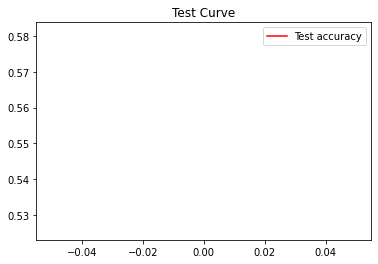


DONE


In [100]:
predictions_val, true_label = predict_pyt(model, test_dataloader)

In [101]:
 Results = pd.DataFrame(
    {'Pred':   predictions_val,
     'Ground': true_label
    })



In [103]:
Results.to_csv('80_20_sum_hir')

In [104]:
from sklearn.metrics import accuracy_score
accuracy_score(Results['Ground'], Results['Pred'])

0.9194305618658186

In [105]:
from sklearn.metrics import f1_score
print(f1_score(Results['Ground'],Results['Pred'],average='macro'))

0.8728940822925686


In [106]:
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(Results['Ground'], Results['Pred'])

In [107]:
from sklearn.metrics import classification_report

target_names = ['class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6',
                'class 7', 'class 8', 'class 9', 'class 10', 'class 11', 'class 12', 
                'class 13', 'class 14', 'class 15', 'class 16', 'class 17', 'class 18',
                'class 19','class 20', 'class 21', 'class 22', 'class 23', 'class 24', 'class 25', 'class 26', 'class 27']

print(classification_report(Results['Ground'], Results['Pred'], target_names=target_names))


              precision    recall  f1-score   support

     class 1       0.82      0.68      0.74        40
     class 2       0.88      0.97      0.93        38
     class 3       0.92      0.93      0.93       145
     class 4       0.83      0.82      0.83       456
     class 5       0.99      0.98      0.98       208
     class 6       0.96      0.96      0.96       455
     class 7       0.84      0.86      0.85       303
     class 8       0.90      0.89      0.89       588
     class 9       0.74      0.79      0.76       189
    class 10       0.94      0.94      0.94       492
    class 11       0.79      0.73      0.76        15
    class 12       0.81      0.84      0.83       113
    class 13       0.98      1.00      0.99      1116
    class 14       0.47      0.44      0.46        18
    class 15       0.99      0.96      0.97       465
    class 16       0.43      0.50      0.46         6
    class 17       0.95      0.98      0.96        42
    class 18       0.89    

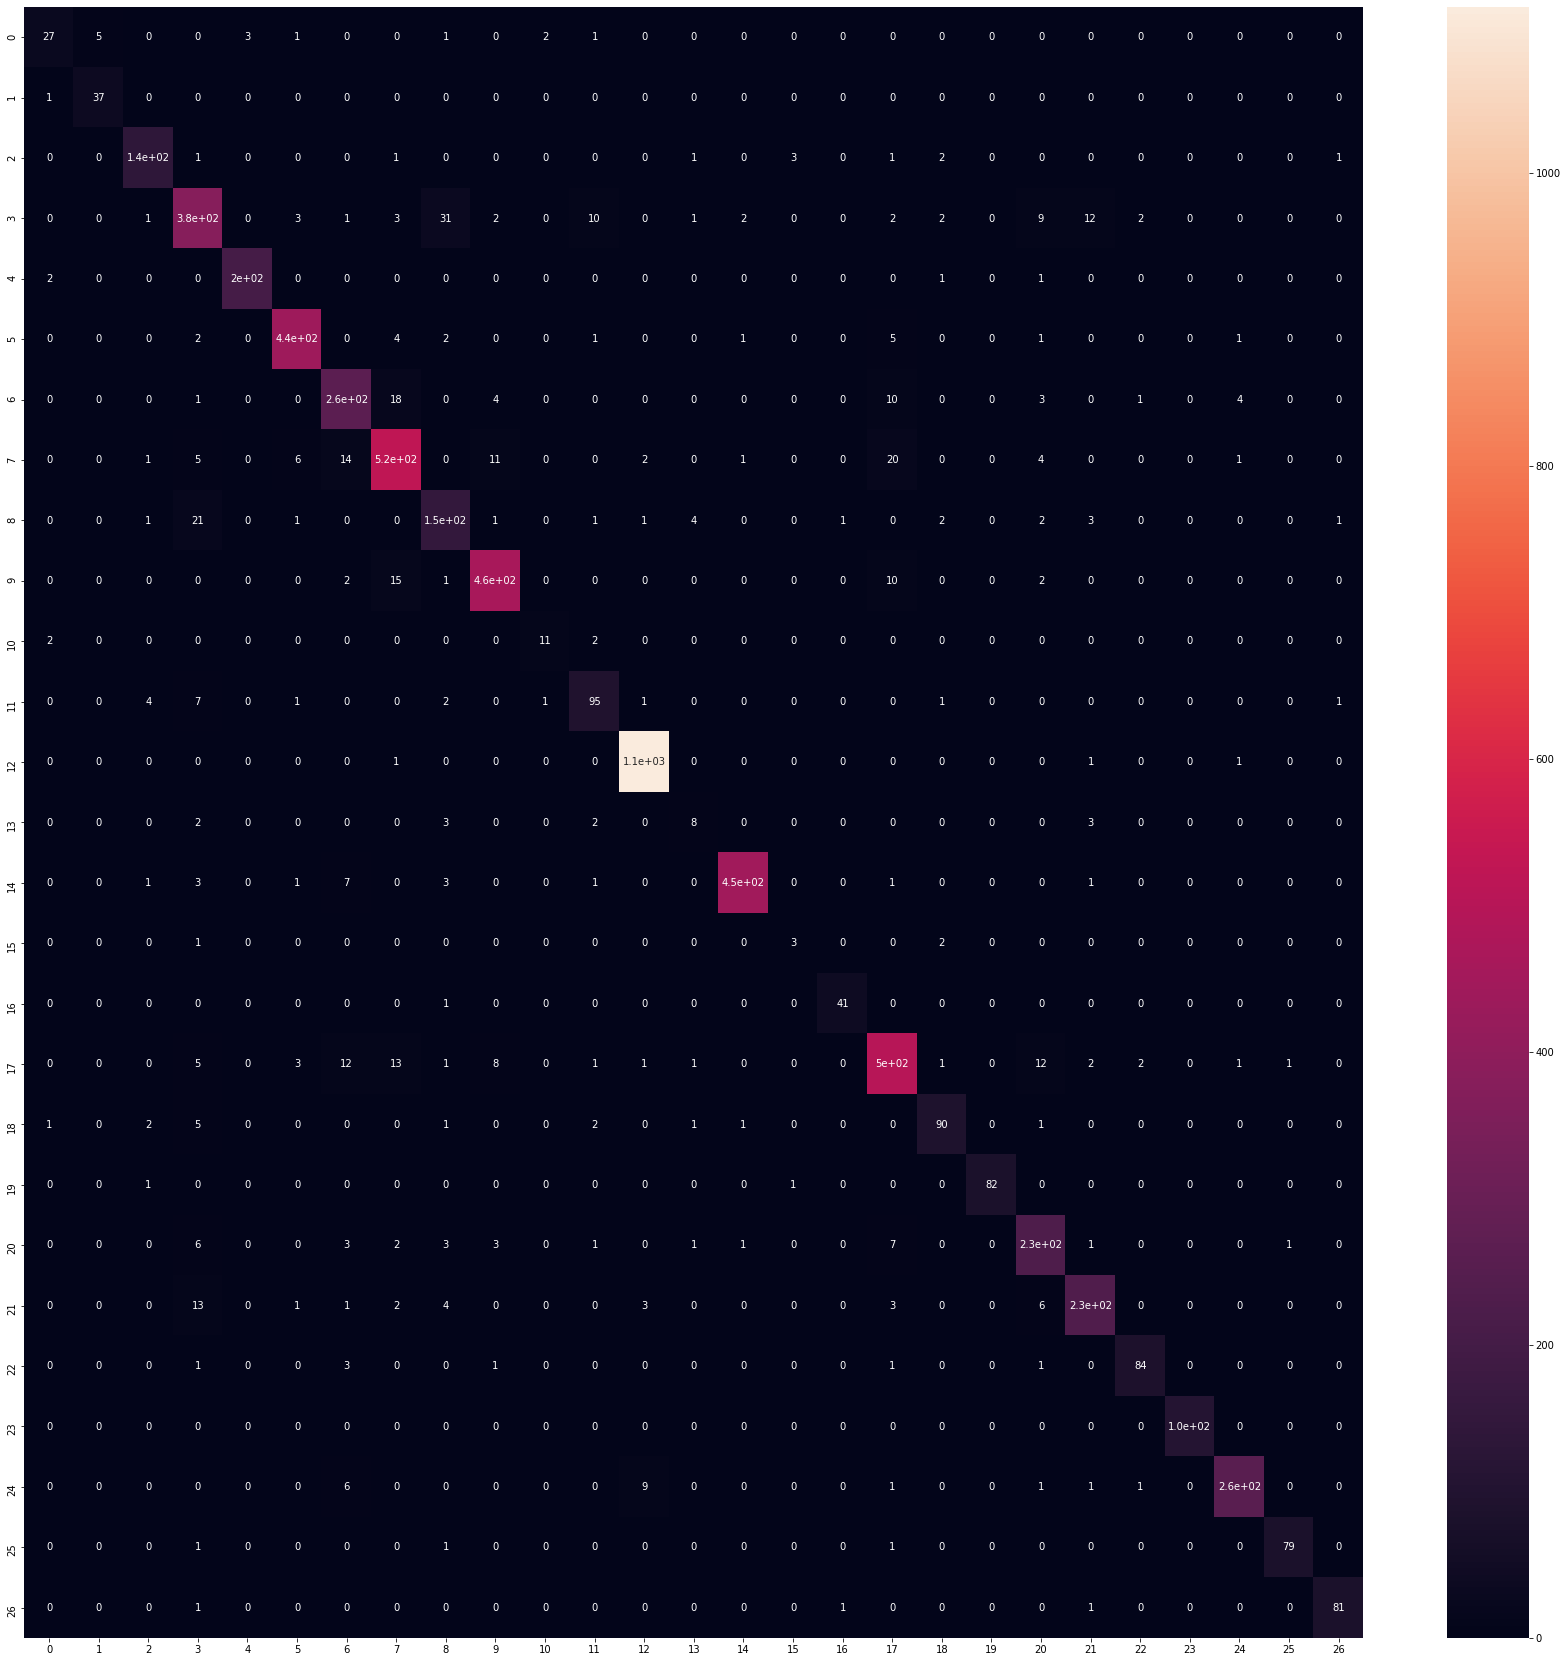

In [108]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusion_mat, index = [i for i in range(27)],
                                    columns = [i for i in range(27)])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)

In [109]:

from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

values = np.array(true_label)
print(values)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
true_label_onehot_encoded = onehot_encoder.fit_transform(integer_encoded)


[23 17  3 ... 12 12 24]
[23 17  3 ... 12 12 24]


In [110]:
values = np.array(predictions_val)
print(values)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
predictions_val_onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

[23  7  3 ... 12 12 24]
[23  7  3 ... 12 12 24]


Automatically created module for IPython interactive environment


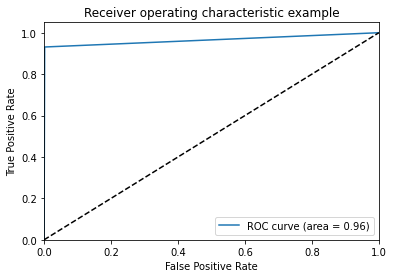

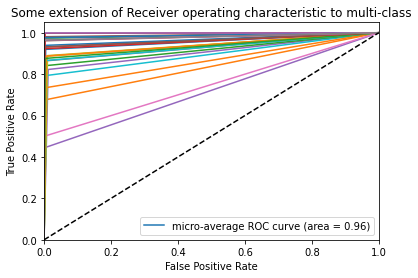

In [112]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier



n_classes = 27

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_label_onehot_encoded[:, i], predictions_val_onehot_encoded[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(true_label_onehot_encoded.ravel(), predictions_val_onehot_encoded.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
# for i in range(n_classes):
#     plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
#                                    ''.format(i, roc_auc[i]))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()